In [ ]:
!pip install -q scikit-learn pandas matplotlib seaborn tensorflow

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
DATAFILE = "kanpur.csv"  # upload this file in Colab
DATETIME_COL = "datetime"            # change if your timestamp column has another name
TARGET = "PM2.5"                     # change to your pollutant column (e.g., 'PM10', 'NO2')
RESAMPLE = "H"                       # 'H' = hourly, 'D' = daily, None = skip resampling

LOOKBACK = 24        # hours of history used for prediction
PRED_STEPS = 1       # predict 1 step ahead
TEST_SIZE = 0.2
VAL_SIZE = 0.1
BATCH_SIZE = 32
EPOCHS = 100
SCALE_METHOD = "minmax"
MODEL_SAVE = "gru_itn_model.h5"

In [ ]:
from google.colab import files
if not os.path.exists(DATAFILE):
    print("Upload your dataset CSV:")
    uploaded = files.upload()
    if uploaded:
        DATAFILE = list(uploaded.keys())[0]

print(f"Loading {DATAFILE} ...")
df = pd.read_csv(DATAFILE, parse_dates=[DATETIME_COL])
df = df.sort_values(DATETIME_COL).reset_index(drop=True)
print("Shape:", df.shape)
display(df.head())

Upload your dataset CSV:


Saving kanpur.csv to kanpur.csv
Loading kanpur.csv ...
Shape: (120, 2)


,datetime,PM2.5
0,2025-11-07 00:00:00,44.1
1,2025-11-07 01:00:00,46.9
2,2025-11-07 02:00:00,48.0
3,2025-11-07 03:00:00,44.8
4,2025-11-07 04:00:00,41.8


In [ ]:
df = df.set_index(DATETIME_COL)

if RESAMPLE:
    df = df.resample(RESAMPLE).mean()

df = df.dropna(how="all")
df = df.interpolate(method="time").ffill().bfill()

print("After cleaning:", df.shape)
display(df.head())

After cleaning: (109, 1)


/tmp/ipython-input-375386710.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(RESAMPLE).mean()


,PM2.5
datetime,
2025-11-07 00:00:00,44.1
2025-11-07 01:00:00,46.9
2025-11-07 02:00:00,48.0
2025-11-07 03:00:00,44.8
2025-11-07 04:00:00,41.8


In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET not in numeric_cols:
    raise ValueError(f"{TARGET} not found in numeric columns: {numeric_cols}")

if SCALE_METHOD == "minmax":
    scaler = MinMaxScaler()
else:
    scaler = StandardScaler()

scaled = scaler.fit_transform(df[numeric_cols])
scaled_df = pd.DataFrame(scaled, index=df.index, columns=numeric_cols)

In [ ]:
def make_sequences(data, target_col, lookback=24, pred_steps=1):
    X, y = [], []
    arr = data.values
    target_idx = data.columns.get_loc(target_col)
    total_len = arr.shape[0]
    for i in range(lookback, total_len - pred_steps + 1):
        X.append(arr[i-lookback:i, :])
        y.append(arr[i + pred_steps - 1, target_idx])
    return np.array(X), np.array(y)

X, y = make_sequences(scaled_df, TARGET, LOOKBACK, PRED_STEPS)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (85, 24, 1) y shape: (85,)


In [ ]:
n = X.shape[0]
test_n = int(n * TEST_SIZE)
val_n = int((n - test_n) * VAL_SIZE)

train_X = X[: n - test_n - val_n]
train_y = y[: n - test_n - val_n]
val_X = X[n - test_n - val_n : n - test_n]
val_y = y[n - test_n - val_n : n - test_n]
test_X = X[n - test_n :]
test_y = y[n - test_n :]

print("Train:", train_X.shape)
print("Val:", val_X.shape)
print("Test:", test_X.shape)

Train: (62, 24, 1)
Val: (6, 24, 1)
Test: (17, 24, 1)


In [ ]:
n_features = X.shape[2]
model = Sequential([
    GRU(64, input_shape=(LOOKBACK, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE, save_best_only=True, monitor="val_loss")
]

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


2/2 - 6s - 3s/step - loss: 0.1762 - mae: 0.3672 - val_loss: 0.4864 - val_mae: 0.6956
Epoch 2/100


2/2 - 0s - 66ms/step - loss: 0.1165 - mae: 0.2926 - val_loss: 0.3643 - val_mae: 0.6023
Epoch 3/100


2/2 - 0s - 91ms/step - loss: 0.0771 - mae: 0.2350 - val_loss: 0.2549 - val_mae: 0.5039
Epoch 4/100


2/2 - 0s - 66ms/step - loss: 0.0478 - mae: 0.1885 - val_loss: 0.1533 - val_mae: 0.3902
Epoch 5/100


2/2 - 0s - 66ms/step - loss: 0.0295 - mae: 0.1489 - val_loss: 0.0742 - val_mae: 0.2694
Epoch 6/100


2/2 - 0s - 71ms/step - loss: 0.0313 - mae: 0.1431 - val_loss: 0.0382 - val_mae: 0.1889
Epoch 7/100


2/2 - 0s - 76ms/step - loss: 0.0411 - mae: 0.1586 - val_loss: 0.0322 - val_mae: 0.1713
Epoch 8/100
2/2 - 0s - 55ms/step - loss: 0.0446 - mae: 0.1686 - val_loss: 0.0421 - val_mae: 0.1987
Epoch 9/100
2/2 - 0s - 54ms/step - loss: 0.0306 - mae: 0.1356 - val_loss: 0.0599 - val_mae: 0.2401
Epoch 10/100
2/2 - 0s - 80ms/step - loss: 0.0229 - mae: 0.1191 - val_loss: 0.0785 - val_mae: 0.2768
Epoch 11/100
2/2 - 0s - 57ms/step - loss: 0.0224 - mae: 0.1225 - val_loss: 0.0958 - val_mae: 0.3069
Epoch 12/100
2/2 - 0s - 62ms/step - loss: 0.0207 - mae: 0.1244 - val_loss: 0.1079 - val_mae: 0.3263
Epoch 13/100
2/2 - 0s - 54ms/step - loss: 0.0213 - mae: 0.1245 - val_loss: 0.1122 - val_mae: 0.3328
Epoch 14/100
2/2 - 0s - 55ms/step - loss: 0.0208 - mae: 0.1215 - val_loss: 0.1087 - val_mae: 0.3274
Epoch 15/100
2/2 - 0s - 68ms/step - loss: 0.0199 - mae: 0.1206 - val_loss: 0.0996 - val_mae: 0.3129
Epoch 16/100
2/2 - 0s - 55ms/step - loss: 0.0195 - mae: 0.1188 - val_loss: 0.0880 - val_mae: 0.2935
Epoch 17/100
2/

In [ ]:
model.load_weights(MODEL_SAVE)
pred_scaled = model.predict(test_X).squeeze()

def inverse_transform_target(scaled_target_arr, original_df, target_col, scaler):
    cols = original_df.columns.tolist()
    idx = cols.index(target_col)
    placeholders = np.zeros((scaled_target_arr.shape[0], len(cols)))
    placeholders[:, idx] = scaled_target_arr
    inv = scaler.inverse_transform(placeholders)[:, idx]
    return inv

pred = inverse_transform_target(pred_scaled, scaled_df, TARGET, scaler)
test_y_inv = inverse_transform_target(test_y, scaled_df, TARGET, scaler)

mae_v = mean_absolute_error(test_y_inv, pred)
rmse_v = np.sqrt(mean_squared_error(test_y_inv, pred))
mape_v = np.mean(np.abs((test_y_inv - pred) / (test_y_inv + 1e-9))) * 100
r2_v = r2_score(test_y_inv, pred)

print(f"\nMetrics:")
print(f"MAE:  {mae_v:.4f}")
print(f"RMSE: {rmse_v:.4f}")
print(f"MAPE: {mape_v:.2f}%")
print(f"R²:   {r2_v:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

Metrics:
MAE:  8.6496
RMSE: 10.8600
MAPE: 16.80%
R²:   0.4506


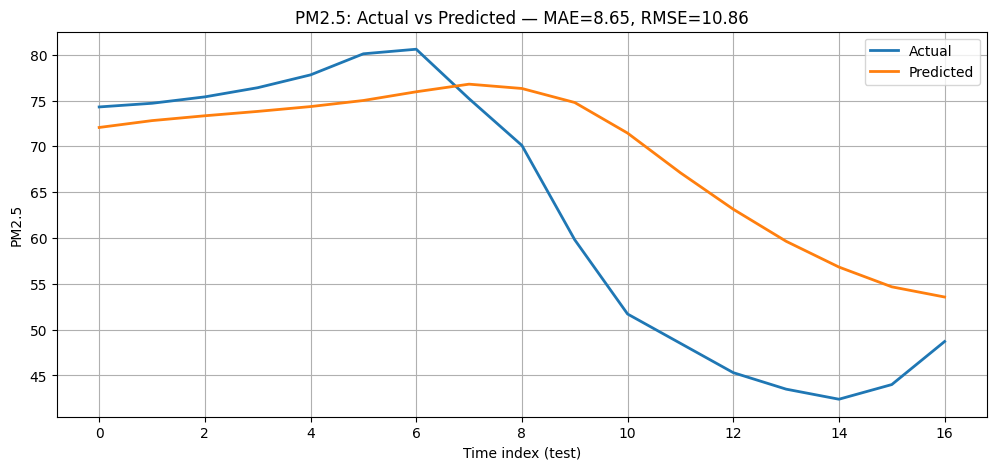

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_y_inv, label="Actual", linewidth=2)
plt.plot(pred, label="Predicted", linewidth=2)
plt.legend()
plt.title(f"{TARGET}: Actual vs Predicted — MAE={mae_v:.2f}, RMSE={rmse_v:.2f}")
plt.xlabel("Time index (test)")
plt.ylabel(TARGET)
plt.grid(True)
plt.show()

In [ ]:
out_df = pd.DataFrame({
    "datetime": df.index[-len(test_y_inv):],
    f"{TARGET}_actual": test_y_inv,
    f"{TARGET}_pred": pred
})
out_df.to_csv("predictions_itn.csv", index=False)
print("Saved predictions_itn.csv")

from google.colab import files
files.download("predictions_itn.csv")

Saved predictions_itn.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>